### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

January 21, 2019

Brian Dew, brian.w.dew@gmail.com, twitter: @bd_econ

Requires: `cpsYYYY.ft` where `YYYY` is the year.

____

Notes:

Several [open issues](https://github.com/bdecon/econ_data/issues) on GitHub. This code needs to do four things: 1) read and aggregate CPS data as instructed (one month, three months, one year, two years); 2) Apply some pre-specified calculations, such as the employment-to-population ratio, unemployment rate, usual earnings at various percentiles, etc.; 3) apply adjustments after the fact, such as moving average, or adjustment for inflation; and 4) allow for collecting data on multiple groups during each read cycle. 

Once the collected data are prepared, use matplotlib to generate nice-looking line plots. 



The [categorization](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of those not in the labor force is provided by the Federal Reserve Bank of Atlanta. 

Useful [pseudocode](https://www.kansascityfed.org/research/kcdc/cps/coreinfo/pseudocode/hrswk) for various CPS-based calculations is provided by the Federal Reserve Bank of Kansas City.

In [1]:
# Import packages, adjust settings and set file path
import os
import pandas as pd
import numpy as np
import wquantiles

os.chdir('/home/brian/Documents/CPS/data/clean/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

# Years of bd CPS data
year_range = range(1994, 2019)   

In [2]:
# Define functions to collect and graph data
def bd_cps_data(query_str, calc_type, smoothing='12sma'):
    """Calculate various labor market indicators from
       bd CPS annual feather files."""
    
    cps_dir = '/home/brian/Documents/CPS/data/'
    
    #Default columns to keep in initial data read
    filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
    keep_cols = []
    
    # Employment-to-population ratio
    if calc_type == 'epop':
        filter_cols = ['EMP', 'PWSSWGT', 'MONTH']
        keep_cols = ['EMPL', 'POP', 'MONTH']
        component_vars = {'EMPL': lambda x: np.where(x['EMP']==1,  x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['EMP'].notnull(), x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['EMPL'] / x['POP'])
        
    # Employment-to-population ratio with care
    if calc_type == 'epopcare':
        filter_cols = ['EMP', 'LMSTAT','PWSSWGT', 'MONTH']
        keep_cols = ['EMPL', 'POP', 'MONTH']
        component_vars = {'EMPL': lambda x: np.where((x['EMP']==1) | (x['LMSTAT']=="NILF - Family"),  x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['EMP'].notnull(), x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['EMPL'] / x['POP'])

    # Unemployment rate
    if calc_type == 'unrate':
        keep_cols = ['UNEMP', 'LF', 'MONTH']
        component_vars = {'UNEMP': lambda x: np.where(x['LMSTAT']=='Unemployed', x['PWSSWGT'], 0),
                          'LF': lambda x: np.where(~x['LMSTAT'].str.contains('NILF'), x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['UNEMP'] / x['LF'])
    
    # Labor force participation rate
    if calc_type == 'lfpr':
        keep_cols = ['LF', 'POP', 'MONTH']
        component_vars = {'LF': lambda x: np.where(~x['LMSTAT'].str.contains('NILF'), x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['LF'] / x['POP'])
        
    # Population in levels (works on age 16+)
    if calc_type == 'pop':
        keep_cols = ['LMSTAT', 'POP', 'MONTH']        
        component_vars = {'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: x['POP'] / 12.0
        
    # Labor union membership (or similar, such as employee association)
    if calc_type == 'union':
        filter_cols = ['PEERNLAB', 'PWORWGT', 'MONTH']
        keep_cols = ['UNION', 'TOT', 'MONTH']
        component_vars = {'TOT': lambda x: np.where(x['PEERNLAB'].isin([1, 2]), x['PWORWGT'], 0),
                          'UNION': lambda x: np.where(x['PEERNLAB']==1, x['PWORWGT'], 0)}
        calc_var = lambda x: (x['UNION'] / x['TOT'])
        
    # Not in the labor force because of disability or illness
    if calc_type == 'nilf_disill':
        filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
        keep_cols = ['DISILL', 'POP', 'MONTH']
        component_vars = {'DISILL': lambda x: np.where(x['LMSTAT']=='NILF - Disabled/ill', x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['DISILL'] / x['POP'])
        
    # NILF - school
    if calc_type == 'nilf_school':
        filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
        keep_cols = ['SCHOOL', 'POP', 'MONTH']
        component_vars = {'SCHOOL': lambda x: np.where(x['LMSTAT']=='NILF - School', 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['SCHOOL'] / x['POP']) 
        
    # NILF - caring for home or others
    if calc_type == 'nilf_care':
        filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
        keep_cols = ['CARE', 'POP', 'MONTH']
        component_vars = {'CARE': lambda x: np.where(x['LMSTAT']=='NILF - Family', 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['CARE'] / x['POP'])      
        
    # NILF - retired
    if calc_type == 'nilf_retired':
        filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
        keep_cols = ['RETIRED', 'POP', 'MONTH']
        component_vars = {'RETIRED': lambda x: np.where(x['LMSTAT']=='NILF - Retired', 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['RETIRED'] / x['POP'])         
        
    # NILF - discourged
    if calc_type == 'nilf_discouraged':
        filter_cols = ['LMSTAT', 'PWSSWGT', 'MONTH']
        keep_cols = ['DISCOURAGED', 'POP', 'MONTH']
        component_vars = {'DISCOURAGED': lambda x: np.where(x['LMSTAT']=='NILF - Discouraged',
                                                           x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['LMSTAT'].notnull(), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['DISCOURAGED'] / x['POP'])       
    
    if len(keep_cols) > 0:
        data = (pd.concat(
            [(pd.read_feather(f'cps{year}.ft', nthreads=3)
                .query(query_str)
                .filter(items = filter_cols)
                .assign(**component_vars)
                .filter(items = keep_cols)
                .groupby('MONTH').sum()
                .pipe(cps_datetime, year)
                .set_index('DATE')) 
            for year in year_range])
                .rolling(12).sum().dropna()
                .assign(FINAL = calc_var)
               )['FINAL']
    
    # Usual hourly earnings - real, at the median
    if calc_type == 'median_hourly_wage_real':
        wage_var = 'RHRWAGE'
    # Usual weekly earnings - real, at the median
    if calc_type == 'median_weekly_wage_real':
        wage_var = 'RWKWAGE'
        
    if 'wage' in calc_type:
        cps_files = pd.Series([pd.to_datetime(file[:5], format='%b%y') 
                               for file in os.listdir(cps_dir) 
                               if file.endswith('.dat')])

        dt_windows = [pd.date_range(end=mo, periods=12, freq='MS') 
                          for mo in cps_files.sort_values()[11:]]

        years = list(set([file.year for file in cps_files]))

        filter_cols = ['YEAR', 'MONTH', wage_var, 'PWORWGT']

        cps_date = lambda x: pd.to_datetime(
            dict(year=x.YEAR, month=x.MONTH, day=1))
        df = pd.concat([
             (pd.read_feather(f'cps{year}.ft', nthreads=3)
                .query('RHRWAGE > 0')
                .query(query_str)
                .filter(filter_cols)
                .assign(DATE = cps_date)
                .drop(['YEAR', 'MONTH'], axis=1)) 
             for year in years])

        data = pd.DataFrame()
        for dw in dt_windows:
            med_wage = binned_wage_calc(df[df['DATE'].isin(dw)], wage_var)
            for key in med_wage.keys():
                data.at[dw[-1], key] = med_wage[key]

    return data


def binned_wage_calc(dfm, wage_var):
    """Return BLS-styled binned median wage"""
    wage_ranges = list(np.arange(0.25,300,0.5))
    if wage_var == 'RWKWAGE':
        wage_ranges = list(np.arange(2.5,3000,0.5))      
    dft = (dfm.sort_values(wage_var)
              .assign(WAGE_RANGE = (lambda x: pd.cut(x[wage_var], wage_ranges, 
                                           include_lowest=True)),
                      CS = lambda x: x['PWORWGT'].cumsum()))
    d = {}
    for pt in [('25th', 0.25), ('50th', 0.5), ('10th', 0.1)]:
        midpt = dft['PWORWGT'].sum() * pt[1]
        mid_interval = dft.iloc[(dft['CS']-midpt).abs().argsort()[:1]].WAGE_RANGE.values[0]

        wage_bins = list(dft['WAGE_RANGE'].unique())

        mi_loc = wage_bins.index(mid_interval)
        lowval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc-1]].iloc[-1].CS
        highval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc]].iloc[-1].CS

        d[pt[0]] = ((((midpt - lowval) / (highval - lowval)) * 0.5) + mid_interval.left)
    
    return(d)


def cps_datetime(df, year):
    """Return DATE '1994-01-01' from HRMONTH and year"""
    df['DATE'] = [pd.to_datetime(f'{year}-{month}-01') 
                  for month in df.index]
    return df 
    

def labor_mkt_grapher(title, data, color):
    """Graph time series data from 1994 to present, with recession bars
       and the most recent monthly data point labeled and annotated."""
    if data.max() <= 1.0:
        ftype = 'pct'
    elif data.max() <= 2000.0:
        ftype = 'usd'
    else:
        ftype = 'people'
    if ftype == 'pct':
        data = data * 100.0
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(figsize=(8, 4), color=color)
    ax = plt.title(title, loc='left')
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    if ftype == 'pct':
        ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    elif ftype == 'usd':
        ax = plt.annotate(f'   ${data[-1]: .2f}', (data.index[-1], data[-1]-spcr2))
    else:
        ax = plt.annotate(f'   {int(data[-1]):,}', (data.index[-1], data[-1]-spcr2))        
    ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')

#### How to use

1) Define the filter query string, for example: `filters = '25 <= AGE <= 54 and FEMALE == 1'`.

2) Give a text name to the group defined above, `group = 'women age 25 to 54'`.

3) Select the calculation (see below), `calc_type = 'epop'`.

4) Customize the title, `title = f'Employed share of population, {group}'`.

5) Call function, `data = bd_cps_data(filters, calc_type)`

6) Graph data (third argument is line color), `labor_mkt_grapher(title, data, 'blue')`


#### List of calc_type options

- `median_weekly_wage_real` (specify decile, e.g. data['10th'])
- `median_hourly_wage_real` (specify decile, e.g. data['10th'])
- `epop`
- `epopcare`
- `unrate`
- `lfpr`
- `pop`
- `union`
- `nilf_disill`
- `nilf_school`
- `nilf_care`
- `nilf_retired`
- `nilf_discouraged`

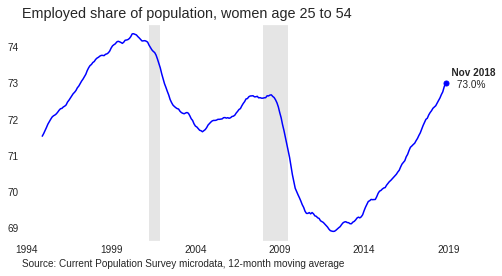

In [3]:
# Example
filters = '25 <= AGE <= 54 and FEMALE == 1'
group = 'women age 25 to 54'
calc_type = 'epop'
title = f'Employed share of population, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

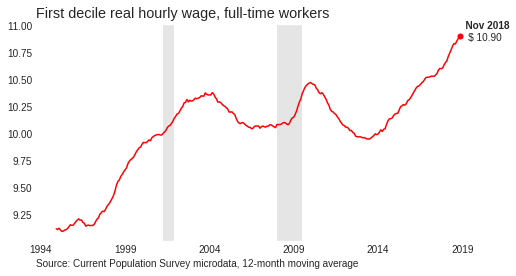

In [4]:
# Example 2
filters = 'PRFTLF == 1'
group = 'full-time workers'
calc_type = 'median_hourly_wage_real'
title = f'First decile real hourly wage, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data['10th'], 'red')

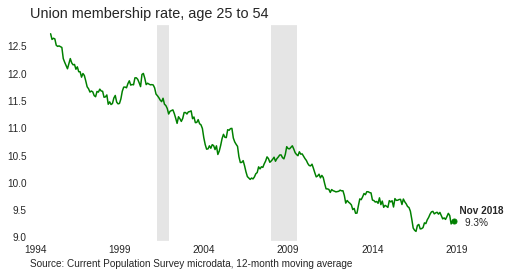

In [3]:
# Example 3
filters = '25 <= AGE <= 34'
group = 'age 25 to 54'
calc_type = 'union'
title = f'Union membership rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')